# **DATA CHALLENGE: CLASSIFICATION DE CHAMPIGNONS-                         THOMAS MARIN GERAUD DE LANGLADE**

# **Introduction**

Dans le cadre de ce projet, l'enjeu est de s'attaquer à une problématique de **classification supervisée** en utilisant le jeu de données disponible [**ici**](https://archive.ics.uci.edu/dataset/73/mushroom). Ce jeu de données, conçu par l'Université de Californie à Irvine (UCI), regroupe des informations diversifiées sur **23 espèces de champignons** (forme du chapeau, présence d'ecchymoses, odeur, etc.). L'objectif est de développer un modèle capable de déterminer si un champignon spécifique est **vénimeux ou comestible**.

Pour élaborer ce modèle, plusieurs **contraintes** doivent être prises en compte :

* Sélectionner uniquement la moitié des données de manière aléatoire.

* Former les modèles en suivant d'abord la **répartition initiale** des individus de classe positive et négative du jeu de données, puis en adoptant des divisions de **30%** d'individus de classe positive et **70%** de classe négative, et finalement **90%** / **10%**.

La classification sera réalisée à l'aide de classifieurs disponibles via le package **`sklearn`**, qui servira également à évaluer les performances des modèles.

Procédons à la mise en œuvre.

In [675]:
import pandas as pd
import numpy as np


In [676]:
!pip install ucimlrepo


[notice] A new release of pip available: 22.3.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


Le package `ucimlrepo` développé par UCI est utilisé pour **charger le dataset et toutes les métadonnées associées**, telles que le nom, le rôle, le type de données, la présence de valeurs manquantes, etc.


In [677]:
from ucimlrepo import fetch_ucirepo

mushroom = fetch_ucirepo(id=73)

data = mushroom.data.original

print(mushroom.variables)

                        name     role         type demographic  \
0                  poisonous   Target  Categorical        None   
1                  cap-shape  Feature  Categorical        None   
2                cap-surface  Feature  Categorical        None   
3                  cap-color  Feature       Binary        None   
4                    bruises  Feature  Categorical        None   
5                       odor  Feature  Categorical        None   
6            gill-attachment  Feature  Categorical        None   
7               gill-spacing  Feature  Categorical        None   
8                  gill-size  Feature  Categorical        None   
9                 gill-color  Feature  Categorical        None   
10               stalk-shape  Feature  Categorical        None   
11                stalk-root  Feature  Categorical        None   
12  stalk-surface-above-ring  Feature  Categorical        None   
13  stalk-surface-below-ring  Feature  Categorical        None   
14    stal

In [678]:
data

,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,stalk-shape,...,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat,poisonous
0,x,s,n,t,p,f,c,n,k,e,...,w,w,p,w,o,p,k,s,u,p
1,x,s,y,t,a,f,c,b,k,e,...,w,w,p,w,o,p,n,n,g,e
2,b,s,w,t,l,f,c,b,n,e,...,w,w,p,w,o,p,n,n,m,e
3,x,y,w,t,p,f,c,n,n,e,...,w,w,p,w,o,p,k,s,u,p
4,x,s,g,f,n,f,w,b,k,t,...,w,w,p,w,o,e,n,a,g,e
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8119,k,s,n,f,n,a,c,b,y,e,...,o,o,p,o,o,p,b,c,l,e
8120,x,s,n,f,n,a,c,b,y,e,...,o,o,p,n,o,p,b,v,l,e
8121,f,s,n,f,n,a,c,b,n,e,...,o,o,p,o,o,p,b,c,l,e
8122,k,y,n,f,y,f,c,n,b,t,...,w,w,p,w,o,e,w,v,l,p


# Preprossecing


## Exploration des Données



Tel que le jeu de données est fourni, **les données sont difficilement compréhensibles**, c'est pourquoi la première étape va être de **transformer les labels en leur véritable noms**, pour chacune des variables du dataset.

 Voici le **mapping** permettant de retrouver le **vrai nom des catégories** de chaque colonne. Celui-ci a été créé à partir de la description des données faites sur le site du dataset.

In [679]:
l_dct_feat = data.to_dict('records')
mapping = {
    'poisonous': {'e': 'edible', 'p': 'poisonous'},
    'cap-shape': {'b': 'bell', 'c': 'conical', 'x': 'convex', 'f': 'flat', 'k': 'knobbed', 's': 'sunken'},
    'cap-surface': {'f': 'fibrous', 'g': 'grooves', 'y': 'scaly', 's': 'smooth'},
    'cap-color': {'n': 'brown', 'b': 'buff', 'c': 'cinnamon', 'g': 'gray', 'r': 'green', 'p': 'pink', 'u': 'purple', 'e': 'red', 'w': 'white', 'y': 'yellow'},
    'bruises': {'t': 'bruises', 'f': 'no'},
    'odor': {'a': 'almond', 'l': 'anise', 'c': 'creosote', 'y': 'fishy', 'f': 'foul', 'm': 'musty', 'n': 'none', 'p': 'pungent', 's': 'spicy'},
    'gill-attachment': {'a': 'attached', 'd': 'descending', 'f': 'free', 'n': 'notched'},
    'gill-spacing': {'c': 'close', 'w': 'crowded', 'd': 'distant'},
    'gill-size': {'b': 'broad', 'n': 'narrow'},
    'gill-color': {'k': 'black', 'n': 'brown', 'b': 'buff', 'h': 'chocolate', 'g': 'gray', 'r': 'green', 'o': 'orange', 'p': 'pink', 'u': 'purple', 'e': 'red', 'w': 'white', 'y': 'yellow'},
    'stalk-shape': {'e': 'enlarging', 't': 'tapering'},
    'stalk-root': {'b': 'bulbous', 'c': 'club', 'u': 'cup', 'e': 'equal', 'z': 'rhizomorphs', 'r': 'rooted', '?': 'missing'},
    'stalk-surface-above-ring': {'f': 'fibrous', 'y': 'scaly', 'k': 'silky', 's': 'smooth'},
    'stalk-surface-below-ring': {'f': 'fibrous', 'y': 'scaly', 'k': 'silky', 's': 'smooth'},
    'stalk-color-above-ring': {'n': 'brown', 'b': 'buff', 'c': 'cinnamon', 'g': 'gray', 'o': 'orange', 'p': 'pink', 'e': 'red', 'w': 'white', 'y': 'yellow'},
    'stalk-color-below-ring': {'n': 'brown', 'b': 'buff', 'c': 'cinnamon', 'g': 'gray', 'o': 'orange', 'p': 'pink', 'e': 'red', 'w': 'white', 'y': 'yellow'},
    'veil-type': {'p': 'partial', 'u': 'universal'},
    'veil-color': {'n': 'brown', 'o': 'orange', 'w': 'white', 'y': 'yellow'},
    'ring-number': {'n': 'none', 'o': 'one', 't': 'two'},
    'ring-type': {'c': 'cobwebby', 'e': 'evanescent', 'f': 'flaring', 'l': 'large', 'n': 'none', 'p': 'pendant', 's': 'sheathing', 'z': 'zone'},
    'spore-print-color': {'k': 'black', 'n': 'brown', 'b': 'buff', 'h': 'chocolate', 'r': 'green', 'o': 'orange', 'u': 'purple', 'w': 'white', 'y': 'yellow'},
    'population': {'a': 'abundant', 'c': 'clustered', 'n': 'numerous', 's': 'scattered', 'v': 'several', 'y': 'solitary'},
    'habitat': {'g': 'grasses', 'l': 'leaves', 'm': 'meadows', 'p': 'paths', 'u': 'urban', 'w': 'waste', 'd': 'woods'}
}

l_dct_feat = [{key: mapping.get(key).get(value)for key, value in dct.items()} for dct in l_dct_feat]
df_main = pd.DataFrame(l_dct_feat)
df_main

,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,stalk-shape,...,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat,poisonous
0,convex,smooth,brown,bruises,pungent,free,close,narrow,black,enlarging,...,white,white,partial,white,one,pendant,black,scattered,urban,poisonous
1,convex,smooth,yellow,bruises,almond,free,close,broad,black,enlarging,...,white,white,partial,white,one,pendant,brown,numerous,grasses,edible
2,bell,smooth,white,bruises,anise,free,close,broad,brown,enlarging,...,white,white,partial,white,one,pendant,brown,numerous,meadows,edible
3,convex,scaly,white,bruises,pungent,free,close,narrow,brown,enlarging,...,white,white,partial,white,one,pendant,black,scattered,urban,poisonous
4,convex,smooth,gray,no,none,free,crowded,broad,black,tapering,...,white,white,partial,white,one,evanescent,brown,abundant,grasses,edible
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8119,knobbed,smooth,brown,no,none,attached,close,broad,yellow,enlarging,...,orange,orange,partial,orange,one,pendant,buff,clustered,leaves,edible
8120,convex,smooth,brown,no,none,attached,close,broad,yellow,enlarging,...,orange,orange,partial,brown,one,pendant,buff,several,leaves,edible
8121,flat,smooth,brown,no,none,attached,close,broad,brown,enlarging,...,orange,orange,partial,orange,one,pendant,buff,clustered,leaves,edible
8122,knobbed,scaly,brown,no,fishy,free,close,narrow,buff,tapering,...,white,white,partial,white,one,evanescent,white,several,leaves,poisonous


Pour **respecter les instructions**, le dataframe original est re-samplé à l'aide de **`frac=0.5`**, retenant ainsi **50% du dataframe original**. En outre, **`random_state=42`** est utilisé pour garantir la **reproducibilité des résultats** en assurant la constance des tirages aléatoires.

In [680]:
df_main = df_main.sample(frac=0.5, random_state=42)

Il est décidé, au regard de la **problématique de santé publique**, que la variable cible sera définie par : "**le champignon est vénimeux**". Il est donc essentiel d'éviter de classer un "champignon vénimeux" en "champignon comestible", **minimisant ainsi les faux négatifs**. En conséquence, une attention particulière sera portée à l'indicateur de performance **False Negative Rate** (FNR) et par conséquent aussi au **recall**, Sachant que:


$$
\text{Recall} = 1 - \text{FNR} = 1 - \left(\frac{FN}{FN + TP}\right)
$$


Il est nécessaire de **vérifier le nombre de catégories présentes dans chaque covariable** afin d'identifier et d'éliminer celles qui ne comportent qu'une seule catégorie, car elles n'apportent **aucune information supplémentaire**.

In [681]:
df_main.nunique()

cap-shape                    6
cap-surface                  4
cap-color                   10
bruises                      2
odor                         9
gill-attachment              2
gill-spacing                 2
gill-size                    2
gill-color                  12
stalk-shape                  2
stalk-root                   4
stalk-surface-above-ring     4
stalk-surface-below-ring     4
stalk-color-above-ring       9
stalk-color-below-ring       9
veil-type                    1
veil-color                   4
ring-number                  3
ring-type                    5
spore-print-color            9
population                   6
habitat                      7
poisonous                    2
dtype: int64

La covariable **`veil-type`** (type de voile du champignon) est donc **supprimée** du dataset.

In [682]:
df_main.drop('veil-type', axis=1, inplace=True)

D'après les métadonnées récupérées avec le jeu de de données, la variable **`stalk-root`** (racine du pied) contient des valeurs manquantes. Vérifions si c'est bien le cas.

In [683]:
print("Pourcentage de valeurs manquantes par covariable:")
print((df_main.isna().sum() / len(df_main) * 100).round(2).astype(str) + '%')

Pourcentage de valeurs manquantes par covariable:
cap-shape                     0.0%
cap-surface                   0.0%
cap-color                     0.0%
bruises                       0.0%
odor                          0.0%
gill-attachment               0.0%
gill-spacing                  0.0%
gill-size                     0.0%
gill-color                    0.0%
stalk-shape                   0.0%
stalk-root                  29.89%
stalk-surface-above-ring      0.0%
stalk-surface-below-ring      0.0%
stalk-color-above-ring        0.0%
stalk-color-below-ring        0.0%
veil-color                    0.0%
ring-number                   0.0%
ring-type                     0.0%
spore-print-color             0.0%
population                    0.0%
habitat                       0.0%
poisonous                     0.0%
dtype: object


Il est observé que le champ **`stalk-root`** presque **30% de valeurs manquantes**. Il est donc nécessaire de décider si la variable `stalk-root` doit être conservée. Pour ce faire, une **régression LASSO** peut être effectuée pour vérifier si les coefficients associés à certaines catégories de cette variable sont significativement différents de zéro, même avec un **hyperparamètre de régularisation** élevé.



In [684]:
from sklearn.linear_model import Lasso

df_one_hot = pd.get_dummies(df_main, dtype= float)

Y = df_one_hot['poisonous_poisonous'].copy()
X = df_one_hot.drop(['poisonous_poisonous', 'poisonous_edible'], axis=1).copy()

lasso_reg_nan = Lasso(alpha=0.01, max_iter=2000)

lasso_reg_nan.fit(X, y = Y)
lasso_reg_nan.coef_

array([-0.00000000e+00,  0.00000000e+00, -0.00000000e+00,  0.00000000e+00,
        0.00000000e+00, -0.00000000e+00, -0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00, -0.00000000e+00,  0.00000000e+00,
       -0.00000000e+00,  0.00000000e+00, -0.00000000e+00,  0.00000000e+00,
       -0.00000000e+00,  0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00,  0.00000000e+00, -4.50432337e-01, -4.57263692e-01,
        0.00000000e+00,  0.00000000e+00,  9.60693394e-02,  0.00000000e+00,
       -6.20837000e-01,  0.00000000e+00,  0.00000000e+00, -0.00000000e+00,
        0.00000000e+00,  0.00000000e+00, -0.00000000e+00, -1.75081322e-01,
        4.65780187e-15, -0.00000000e+00, -0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00,  0.00000000e+00, -0.00000000e+00,  1.89024257e-02,
       -0.00000000e+00,  

In [685]:
mapping_col_lasso_coef = [col for col, coef in zip(X.columns, lasso_reg_nan.coef_) if coef != 0]
mapping_col_lasso_coef

['odor_almond',
 'odor_anise',
 'odor_foul',
 'odor_none',
 'gill-size_broad',
 'gill-size_narrow',
 'stalk-root_bulbous',
 'stalk-surface-above-ring_silky',
 'stalk-surface-above-ring_smooth',
 'ring-type_pendant',
 'spore-print-color_black',
 'spore-print-color_brown',
 'spore-print-color_chocolate',
 'population_several']

Il est constaté que **`stalk-root_bulbous`** figure parmi les **14 sous-covariables** (obtenues après binarisation) ayant le plus d'impact sur la vénéneusité d'un champignon. Étant donné que cette catégorie est liée à la covariable **`stalk-root`**, la décision est prise de **ne pas supprimer** la variable **`stalk-root`** du dataframe original.


**Voir comment gérer la binarisation, car si une catégorie de la covariable est très peu présente alors il vaut mieux il vaut mieux fixer une borne haute assez basse afin d'avoir plus de 1 pour cette variable et donc plus d'exemples avec cette valeur disponibles.**



# Gérer les valeurs manquantes

Plusieurs stratégies sont envisageables pour gérer les **valeurs manquantes**. Parmi les techniques simples, on peut remplacer ces valeurs en utilisant la catégorie **la plus fréquente**, les traiter comme une **nouvelle catégorie**, ou **imputer une nouvelle valeur** en tenant compte des valeurs des autres colonnes. Cette dernière méthode est celle que nous allons tenter de mettre en place.

Étant donné qu'il s'agit de **valeurs catégoriques manquantes**, il sera nécessaire de **binariser** toutes nos covariables, puis d'utiliser un **"imputer"**.



Le processus commence par la **catégorisation des données**. Pour prendre en compte les valeurs manquantes (**`NaN`**), une variable binarisée supplémentaire est créée pour chaque colonne à binariser. Par exemple, si **6 variables** doivent être binarisées dans le **dataframe original**, **6 colonnes supplémentaires** seront ajoutées dans la **version binarisée** du dataframe, toutes ces colonnes se terminant par **`_nan`**. Ces colonnes permettent d'**identifier les lignes** du dataframe qui **contiennent des valeurs manquantes** pour une variable catégorielle spécifique du dataframe original. Dans ces colonnes, un **1** marque la présence d'une valeur manquante, **0** sinon.

Pour catégoriser les variables, la fonction **`pandas.get_dummies`** est utilisée avec l'argument **`dummy_na=True`** pour générer les colonnes **`_nan`** et **`dtype=float`** afin d'obtenir un dataframe rempli de **0.0** et **1.0**. Cette configuration assure que les données soient déjà dans le **format supporté** par l'**imputer**.


In [686]:
df_one_hot = pd.get_dummies(df_main, dummy_na=True, dtype= float)
df_one_hot

,cap-shape_bell,cap-shape_conical,cap-shape_convex,cap-shape_flat,cap-shape_knobbed,cap-shape_sunken,cap-shape_nan,cap-surface_fibrous,cap-surface_grooves,cap-surface_scaly,...,habitat_leaves,habitat_meadows,habitat_paths,habitat_urban,habitat_waste,habitat_woods,habitat_nan,poisonous_edible,poisonous_poisonous,poisonous_nan
1971,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
6654,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
5606,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3332,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
6988,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3226,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4515,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
7770,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1626,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


Toutes les colonnes **`'_nan'`** qui ne sont pas liées à la colonne du dataframe original contenant des valeurs manquantes (**`stalk-root`**) sont **supprimées**. Ces colonnes sont **inutiles pour la méthode d'impution qui va être utilisée** car elles sont associées à des colonnes du dataframe original **sans valeurs manquantes**, et sont donc **remplies uniquement de 0**.


In [687]:
for col in [col_name for col_name in df_one_hot.columns if not col_name.startswith('stalk-root')]:
    if 'nan' in col:
        df_one_hot.drop(col, axis=1, inplace=True)

Il est maintenant possible de transformer les **4 sous-variables créées** lors de la binarisation en inputant des **`NaN`** aux lignes où la colonne **`stalk-root_nan`** est égale à **1** (**indiquant la présence de valeurs manquantes**). Pour cela, on sélectionne toutes les colonnes binarisées commençant par **`stalk-root`** et qui ne finissent pas par **`'_nan'`**; il y en a **4 qui satisfont ces critères**. Ensuite, il suffit d'inputer les **NaNs** dans ces colonnes. Pour finir, on supprime la colonne **`'_nan'`** de la covariable **`stalk-root`** car elle n'est plus nécessaire.


In [688]:
columns_to_modify = [col for col in df_one_hot.columns if col.startswith('stalk-root') and 'nan' not in col]

for col in columns_to_modify:
    df_one_hot.loc[df_one_hot['stalk-root_nan'] == 1, col] = np.nan

df_one_hot.drop('stalk-root_nan', axis=1, inplace=True)

Plusieurs modèles sont appropriés pour l'imputation de données. Le **`KNN`** est utilisé ici car c'est une des **méthodes les plus simples et efficaces** pour l'imputation de données, et elle fonctionne particulièrement bien pour les **données catégorielles** (transformées en données binaires). Il est également important de noter que cette méthode est **particulièrement adaptée lorsque seulement une covariable du dataset contient des valeurs manquantes**. En effet, si plusieurs covariables du dataset présentent des valeurs manquantes, le **`KNNImputer`** gère d'une manière spécifique qui ne corresponds pas forcément à certaines approches (il pondère la distance euclidienne à un individu en fonction du nombre de valeurs manquantes sur l'ensemble des caractéristiques de l'individu).


In [689]:
from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors=5)
df_imputed = pd.DataFrame(imputer.fit_transform(df_one_hot), columns=df_one_hot.columns)

L'imputer a rempli les valeurs manquantes dans les **4 colonnes binarisées** avec des valeurs situées entre 0 et 1. Étant donné qu'il s'agit de colonnes binaires, il est nécessaire que les valeurs de ces colonnes soient soit **1** soit **0**, et que la somme sur chaque ligne de ces 4 colonnes soit égale à **1** (une observation ne peut être associée qu'à une seule catégorie).


Il a donc été décidé de fixer deux seuils pour l'imputation des valeurs : l'un en dessous duquel la valeur sera inputée comme **0** (les valeurs en dessous de **0.2**) et l'autre au-dessus duquel la valeur sera considérée comme **1** (valeurs au-dessus de **0.8**). En pratique, il s'agirait d'hyperparamètres à optimiser via une validation croisée. Cependant, étant donné que cette covariable est une parmi 22 autres, l'impact de l'optimisation de ces hyperparamètres sur les résultats finaux du modèle est limité. Ainsi, la décision de choisir ces seuils a été guidée par le bon sens.

In [690]:
for col in columns_to_modify:
    df_imputed.loc[df_imputed[col] >= 0.8, col] = 1.0
    df_imputed.loc[df_imputed[col] <= 0.2, col] = 0.0
    df_imputed.loc[df_imputed[col].apply(lambda x: 0.2 < x < 0.8), col] = -1

Tous les individus présentant toujours des **`NaN`** après le processus d'imputation sont supprimés. Cela concerne les lignes du dataframe qui contiennent au moins un **-1** (valeurs d'imputation situées dans l'intervalle **]0.2, 0.8[**).


In [691]:
df_imputed = df_imputed[~(df_imputed == -1).any(axis=1)]
df_imputed

,cap-shape_bell,cap-shape_conical,cap-shape_convex,cap-shape_flat,cap-shape_knobbed,cap-shape_sunken,cap-surface_fibrous,cap-surface_grooves,cap-surface_scaly,cap-surface_smooth,...,population_solitary,habitat_grasses,habitat_leaves,habitat_meadows,habitat_paths,habitat_urban,habitat_waste,habitat_woods,poisonous_edible,poisonous_poisonous
0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4056,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4057,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4058,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
4060,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


Un **remappage des données** est ensuite réalisé afin d'**obtenir le dataframe original** sans aucune donnée manquante.

In [692]:
df_imputed

,cap-shape_bell,cap-shape_conical,cap-shape_convex,cap-shape_flat,cap-shape_knobbed,cap-shape_sunken,cap-surface_fibrous,cap-surface_grooves,cap-surface_scaly,cap-surface_smooth,...,population_solitary,habitat_grasses,habitat_leaves,habitat_meadows,habitat_paths,habitat_urban,habitat_waste,habitat_woods,poisonous_edible,poisonous_poisonous
0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4056,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4057,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4058,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
4060,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


**Mapping inverse (variable binaire -> variable catégorielle)**

In [693]:
import copy

l_dct_imputed = df_imputed.to_dict('records')
l_dct = []
col_names_dct = {col_name.split('_')[0]: '' for col_name in l_dct_imputed[0]}
for dct in l_dct_imputed:
    new_dct = copy.deepcopy(col_names_dct)
    for col, value in dct.items():
        if value == 1.0:
            name_splits = col.split('_')
            new_dct[name_splits[0]] = name_splits[1]
    l_dct.append(new_dct)

df_main = pd.DataFrame(l_dct)


In [694]:
df_main = pd.DataFrame(l_dct)
df_main.isna().sum()

cap-shape                   0
cap-surface                 0
cap-color                   0
bruises                     0
odor                        0
gill-attachment             0
gill-spacing                0
gill-size                   0
gill-color                  0
stalk-shape                 0
stalk-root                  0
stalk-surface-above-ring    0
stalk-surface-below-ring    0
stalk-color-above-ring      0
stalk-color-below-ring      0
veil-color                  0
ring-number                 0
ring-type                   0
spore-print-color           0
population                  0
habitat                     0
poisonous                   0
dtype: int64

Le jeu de données **ne contient plus de valeur manquantes**

Étant donné la présence de **plus de 100 sous-covariables** dans le jeu de données, il est envisagé de réduire ce nombre afin d'éviter l'**overfitting** du modèle de classification.


# **Réduction de la dimensionalité**

Pour réduire le nombre de covariables utilisées pour entraîner notre modèle, des techniques telles que l'**ACP** ou une régression **LASSO** peuvent être envisagées. La régression **LASSO** est une bonne option car elle permet de conserver l'interprétabilité directe des covariables sur les résultats. Bien que certains modèles, comme **`LogisticRegression`** de **sklearn**, offrent directement des hyperparamètres pour une réduction de dimension via **Lasso**, il est souhaitable de généraliser cette réduction indépendamment du classifieur utilisé.


In [695]:
df_main_bin = pd.get_dummies(df_main, dtype=float)

In [696]:
Y = df_main_bin['poisonous_poisonous'].copy()
X = df_main_bin.drop(['poisonous_poisonous', 'poisonous_edible'], axis=1).copy()

Il a été décidé de ne retenir que les **10 sous-covariables les plus significatives** pour indiquer qu'un champignon est vénimeux. Cette sélection permet d'éviter l'**overfitting** du modèle et de réduire considérablement le **travail de constitution du jeu de données**, facilitant ainsi l'utilisation du modèle sur de nouveaux champignons à l'avenir.


In [697]:
from sklearn.linear_model import Lasso

alpha = 0.001
l_col_to_consider = []
col_to_drop = ['bruises_no', 'gill-size_broad']
while len(l_col_to_consider) != 10:
    lasso_reg = Lasso(alpha, max_iter=2000)
    lasso_reg.fit(X, y = Y)
    l_col_to_consider = [col for col, coef in zip(X.columns, lasso_reg.coef_) if coef != 0 and col not in col_to_drop]
    alpha += 0.002
    print(f"Pour alpha = {round(alpha, 4)}, le modèle retient {len(l_col_to_consider)} sous-covariables")

Pour alpha = 0.003, le modèle retient 29 sous-covariables
Pour alpha = 0.005, le modèle retient 19 sous-covariables
Pour alpha = 0.007, le modèle retient 17 sous-covariables
Pour alpha = 0.009, le modèle retient 17 sous-covariables
Pour alpha = 0.011, le modèle retient 14 sous-covariables
Pour alpha = 0.013, le modèle retient 14 sous-covariables
Pour alpha = 0.015, le modèle retient 13 sous-covariables
Pour alpha = 0.017, le modèle retient 13 sous-covariables
Pour alpha = 0.019, le modèle retient 13 sous-covariables
Pour alpha = 0.021, le modèle retient 11 sous-covariables
Pour alpha = 0.023, le modèle retient 10 sous-covariables


Il est observé que le fait qu'un champignon **ne soit pas odorant** a un impact très significatif sur sa **vénénosité**, dominant largement les 9 autres covariables les plus significatives.

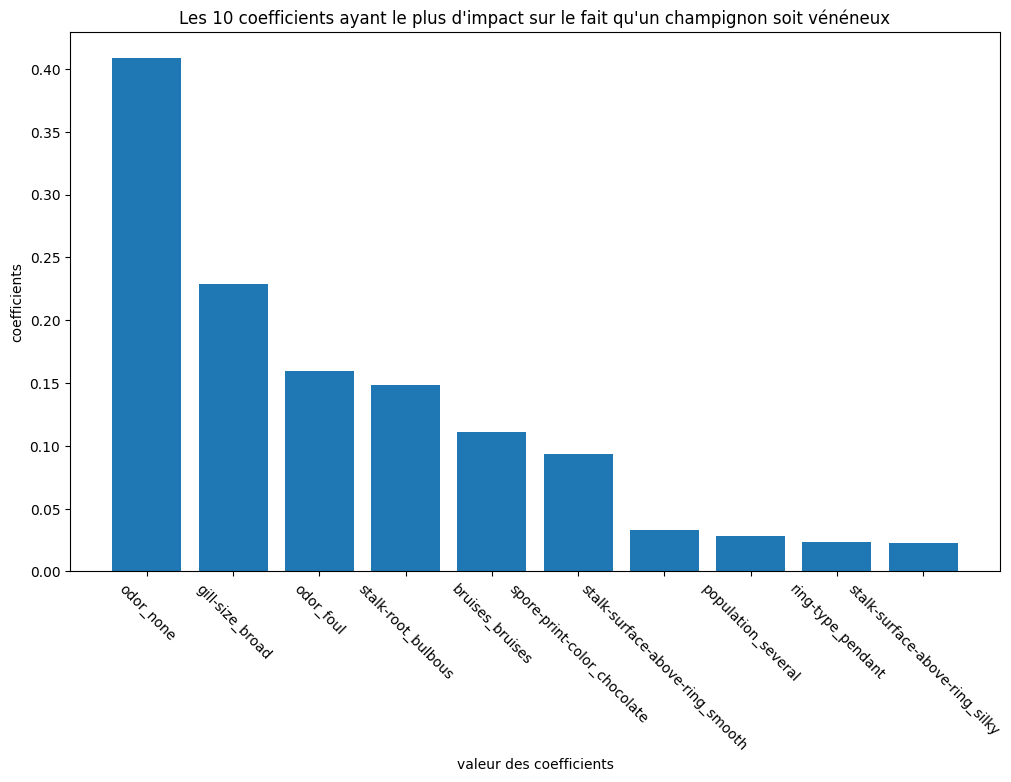

In [698]:
import matplotlib.pyplot as plt


l_col_to_consider_raw = [(col, abs(coef)) for col, coef in zip(X.columns, lasso_reg.coef_) if round(coef, 5) != 0]
col_to_consider = sorted(l_col_to_consider_raw, key=lambda col: col[1], reverse=True)

col_name, coefs = zip(*col_to_consider)

plt.figure(figsize=(12, 7))

plt.bar(col_name, coefs)
plt.xticks(rotation=-45)
plt.xlabel('valeur des coefficients')
plt.ylabel('coefficients')
plt.title('Les 10 coefficients ayant le plus d\'impact sur le fait qu\'un champignon soit vénéneux')

plt.show()

In [699]:
len(l_col_to_consider)
l_col_to_consider

['bruises_bruises',
 'odor_foul',
 'odor_none',
 'gill-size_narrow',
 'stalk-root_bulbous',
 'stalk-surface-above-ring_silky',
 'stalk-surface-above-ring_smooth',
 'ring-type_pendant',
 'spore-print-color_chocolate',
 'population_several']

Seulement les **10 sous covariable** les plus significatives du dataframe binarisé sont donc **gardées** pour **l'entrainement des modèles de classification**

In [700]:
df_features = X[l_col_to_consider].copy()

## **Vérification de l'indépendance des covariables**


Avant de lancer l'entraînement des classifieurs, il est crucial de vérifier si les variables sélectionnées sont indépendantes entre elles pour éviter la redondance des covariables en entrée des modèles.

Pour cela, un test de $\chi^2$ sera réalisé pour évaluer l'association entre les sous-covariables parmi les 10 précédemment sélectionnées.

La formule du test de $\chi^2$ est la suivante :

La formule de la statistique de test du $\chi^2$ d'indépendance est :

$$
\chi^2 = \sum \frac{(O_{ij} - E_{ij})^2}{E_{ij}}
$$

où :
- $(O_{ij})$ est la fréquence observée dans la cellule de la table de contingence à l'intersection de la i-ème ligne et de la j-ème colonne,
- $(E_{ij})$ est la fréquence attendue pour la cellule, calculée par :



$$
E_{ij} = \frac{(n_{i.} \times n_{.j})}{n}
$$

- $(n_{i.})$ est le total de la i-ème ligne,
- $(n_{.j})$ est le total de la j-ème colonne,
- $(n)$ est le total général de toutes les observations dans la table.




In [779]:
import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency, chi2

def get_chi2_test(df, seuil):
    cat_vars = df.columns.tolist()
    i = 0
    count_res = 0
    l_failed_asso = []
    l_var1 = []
    l_stat_test = []
    for var1 in cat_vars:
        l_var1.append(var1)
        for var2 in cat_vars:
            if var1 != var2 and var2 not in l_var1:
                table = pd.crosstab(df[var1], df[var2])
                chi2_stat, _, _, _ = chi2_contingency(table)
                critical_val = chi2.ppf(seuil, df=1)
                if chi2_stat<critical_val:
                    count_res += 1
                else:
                    l_failed_asso.append((var1, var2))
                l_stat_test.append()
                i += 1
    
    print(f"Pourcentage de tests valides à un seuil de confiance de {100*seuil:.0f}% : {100*(count_res/i):.2f}%" + '\n')
    print('Voici la liste des associations de variables qui n\'ont pas passée le test:' + '\n')
    for asso in l_failed_asso:
        print(f"{asso[0]} et {asso[1]}")

In [799]:
chi2.ppf(0.9999999999999999, df=1)

68.7632522116684

In [801]:
# test à un seuil de confiance de 99%
get_chi2_test(df_features, 0.99)

Pourcentage de tests valides à un seuil de confiance de 99% : 6.67%

Voici la liste des associations de variables qui n'ont pas passée le test:

bruises_bruises et odor_foul
bruises_bruises et odor_none
bruises_bruises et gill-size_narrow
bruises_bruises et stalk-surface-above-ring_silky
bruises_bruises et stalk-surface-above-ring_smooth
bruises_bruises et ring-type_pendant
bruises_bruises et spore-print-color_chocolate
bruises_bruises et population_several
odor_foul et odor_none
odor_foul et gill-size_narrow
odor_foul et stalk-root_bulbous
odor_foul et stalk-surface-above-ring_silky
odor_foul et stalk-surface-above-ring_smooth
odor_foul et ring-type_pendant
odor_foul et spore-print-color_chocolate
odor_foul et population_several
odor_none et gill-size_narrow
odor_none et stalk-root_bulbous
odor_none et stalk-surface-above-ring_silky
odor_none et stalk-surface-above-ring_smooth
odor_none et ring-type_pendant
odor_none et spore-print-color_chocolate
odor_none et population_several
gill-

Ainsi, **93.33%** des associations de sous-covariables **ne passent pas le test d'indépendance** du $\chi^2$ avec un seuil de confiance à **99%**, ce qui peut sembler est très élevé. Cela s'explique principalement par le fait que, les champignons **possèdent des caractéristiques qui sont souvent corrélées**. Par exemple, la couleur, la forme, et la surface du chapeau peuvent toutes être liées à la comestibilité. Néanmoins, il est important de noter qu'elles **conservent chacune une partie de leur information qui diffère des autres sous-covariables**. D'où le fait pour qu'**aucune sous-covariable ne sera retirée** des données d'entrainement.

# Entrainement du modèle

À partir de l'échantillon pré-traité, et en réponse aux **problématiques d'équilibrage du jeu d'entraînement**, la fonction **`dataset_divider`** a été créée pour **biaiser** ce dernier en fonction de la **proportion d'exemples positifs demandée** dans le dataframe d'entraînement.


En complément, pour **faciliter l'entraînement et la validation des modèles**, la fonction **`train_model_and_predict`** a été développée. Cette fonction permet d'entraîner le modèle et de fournir des prédictions sur l'échantillon de test. Elle prend en charge les modèles **Logistic Regression** (un modèle simple mais efficace pour les tâches de classification) et **Random Forest** (un modèle hautement performant en classification), tous deux implémentés via **scikit-learn**.



La fonction **`get_score`** a été ajoutée pour permettre, à partir des labels de l'échantillon de test et des prédictions obtenues, de mesurer l'**accuracy** (pertinente dans les jeux de données équilibrés) et surtout le **recall** (crucial dans les cas où la **maximisation des vrais positifs** est nécessaire, comme c'est le cas ici, pour **éviter les faux-négatifs**).

Enfin, la fonction **`cross_val`** a été ajoutée pour **englober les trois fonctions précédentes**, facilitant ainsi la réalisation d'une **validation croisée**, essentielle pour confirmer **la robustesse des résultats d'un modèle**.



In [903]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

def dataset_divider(df, class_1_percent=None):
    if not class_1_percent:
        return df
    mask_ones = df['target'] == 1
    freq_ones = len(df[mask_ones])/len(df)

    if class_1_percent > freq_ones:
        num_ones = (mask_ones).sum()
        num_zeroes = int(num_ones * (1 - class_1_percent) / class_1_percent)
        df_zeroes = df[~mask_ones].sample(num_zeroes)
        df_out = pd.concat([df[mask_ones], df_zeroes])
    else:
        num_zeroes = (~mask_ones).sum()
        num_ones = int(num_zeroes * class_1_percent / (1 - class_1_percent))
        df_ones = df[mask_ones].sample(num_ones)
        df_out = pd.concat([df[~mask_ones], df_ones])

    return df_out.reset_index()


def train_model_and_predict(df, model_name = 'random_forest', test_size = 0.2):

    X = df.drop('target', axis=1)
    y = df['target']
    X_train, X_test, y_train, y_test  = train_test_split(X, y, test_size=test_size, stratify=y)

    if model_name == 'random_forest':
        model = RandomForestClassifier()
    elif model_name == 'log_reg':
        model = LogisticRegression(max_iter=4000)

    model.fit(X_train, y= y_train)

    predictions = model.predict(X_test)

    return model, predictions, y_test


def get_score(predicted_values, true_values, score_type ='accuracy', in_percent = False):

    y_test_array = true_values.to_numpy()

    count=0
    TP = 0
    FN = 0
    for predicted_val, truth_val in zip(predicted_values, y_test_array):
        if score_type == "accuracy":
            if predicted_val == truth_val:
                count += 1
        elif score_type == "recall":
            if predicted_val == truth_val and truth_val == 1:
                TP += 1
            if predicted_val != truth_val and truth_val == 1:
                FN += 1

    if score_type == "accuracy":
        score = count/len(y_test_array)
    elif score_type == "recall":
        score = TP/(TP+FN)
    if in_percent:
        return f"{100*score:.2f}%"

    return round(score, 4)


def cross_val(df, class_1_percent, model_name, n_cross_val, score_type = 'accuracy', in_percent = True):

    l_scores = []
    for i in range(n_cross_val):
        df_biaised = dataset_divider(df, class_1_percent)
        model, preds, y_test = train_model_and_predict(df_biaised, model_name, test_size = 0.2)
        l_scores.append(get_score(preds, y_test, score_type))
    score = np.mean(l_scores)
    std_score = np.std(l_scores)
    confidence_interval = (score - 1.96*std_score, score + 1.96*std_score)
    if confidence_interval[1] > 1:
        confidence_interval = (confidence_interval[0], 1)
    if in_percent:
        return f"{100*score:.2f}%", f"[{100*confidence_interval[0]:.2f}%, {100*confidence_interval[1]:.2f}%]"

    return round(score, 4), confidence_interval



La variable cible est **remise dans le dataframe d'entrainement pour le calcul des scores** pour les deux modèles choisis.


In [708]:
df_main = df_features.copy()
df_main['target'] = Y

In [709]:
df_main

,bruises_bruises,odor_foul,odor_none,gill-size_narrow,stalk-root_bulbous,stalk-surface-above-ring_silky,stalk-surface-above-ring_smooth,ring-type_pendant,spore-print-color_chocolate,population_several,target
0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0
2,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0
3,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0
4,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
3905,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0
3906,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0
3907,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0
3908,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### **Résultats avec la Régression Logistique**

In [891]:
prop_1_unbiased_df = df_main['target'].value_counts()[0]/len(df_main)
l_prop_to_bias = [0.1, 0.3, prop_1_unbiased_df]

for prop in l_prop_to_bias:
    accu, conf_inter_acc= cross_val(df_main, prop, model_name = 'log_reg', n_cross_val = 50, score_type = 'accuracy', in_percent = True)
    recall, conf_inter_rec= cross_val(df_main, prop, model_name = 'log_reg', n_cross_val = 50, score_type = 'recall', in_percent = True)
    print(f"""L'accuracy pour le modèle de régression logistique avec un pourcentage de champignons vénéneux dans le dataset original de {100*prop:.2f}%
est égal à: {accu}, intervalle de confiance: {conf_inter_acc}""")
    print(f"""Le recall pour le modèle de régression logistique avec un pourcentage de champignons vénéneux dans le dataset original de {100*prop:.2f}%
est égal à: {recall}, intervalle de confiance: {conf_inter_rec}""")

L'accuracy pour le modèle de régression logistique avec un pourcentage de champignons vénéneux dans le dataset original de 10.00%
est égal à: 98.79%, intervalle de confiance: [97.70%, 99.88%]
Le recall pour le modèle de régression logistique avec un pourcentage de champignons vénéneux dans le dataset original de 10.00%
est égal à: 88.62%, intervalle de confiance: [79.50%, 97.74%]
L'accuracy pour le modèle de régression logistique avec un pourcentage de champignons vénéneux dans le dataset original de 30.00%
est égal à: 96.76%, intervalle de confiance: [95.17%, 98.35%]
Le recall pour le modèle de régression logistique avec un pourcentage de champignons vénéneux dans le dataset original de 30.00%
est égal à: 95.57%, intervalle de confiance: [91.25%, 99.89%]
L'accuracy pour le modèle de régression logistique avec un pourcentage de champignons vénéneux dans le dataset original de 51.61%
est égal à: 97.29%, intervalle de confiance: [96.38%, 98.19%]
Le recall pour le modèle de régression log

### **Résultats avec Random Forest**

In [894]:
prop_1_unbiased_df = df_main['target'].value_counts()[0]/len(df_main)
l_prop_to_bias = [0.1, 0.3, prop_1_unbiased_df]

for prop in l_prop_to_bias:
    accu, conf_inter_acc= cross_val(df_main, prop, model_name = 'random_forest', n_cross_val = 50, score_type = 'accuracy', in_percent = True)
    recall, conf_inter_rec= cross_val(df_main, prop, model_name = 'random_forest', n_cross_val = 50, score_type = 'recall', in_percent = True)
    print(f"""L'accuracy pour le modèle random forest avec un pourcentage de champignons vénéneux dans le dataset original de {100*prop:.2f}%
est égal à: {accu}, intervalle de confiance: {conf_inter_acc}""")
    print(f"""Le recall pour le modèle random forest avec un pourcentage de champignons vénéneux dans le dataset original de {100*prop:.2f}%
est égal à: {recall}, intervalle de confiance: {conf_inter_rec}""")


L'accuracy pour le modèle random forest avec un pourcentage de champignons vénéneux dans le dataset original de 10.00%
est égal à: 99.64%, intervalle de confiance: [99.09%, 100.00%]
Le recall pour le modèle random forest avec un pourcentage de champignons vénéneux dans le dataset original de 10.00%
est égal à: 96.80%, intervalle de confiance: [91.86%, 100.00%]
L'accuracy pour le modèle random forest avec un pourcentage de champignons vénéneux dans le dataset original de 30.00%
est égal à: 98.91%, intervalle de confiance: [98.12%, 99.71%]
Le recall pour le modèle random forest avec un pourcentage de champignons vénéneux dans le dataset original de 30.00%
est égal à: 98.15%, intervalle de confiance: [96.01%, 100.00%]
L'accuracy pour le modèle random forest avec un pourcentage de champignons vénéneux dans le dataset original de 51.61%
est égal à: 98.44%, intervalle de confiance: [97.71%, 99.16%]
Le recall pour le modèle random forest avec un pourcentage de champignons vénéneux dans le dat

### **Evolution de la courbe ROC en fonction**

/var/folders/kn/pl0971pj1p358ll4phkv7xgw0000gn/T/ipykernel_27838/3525203263.py:34: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm)


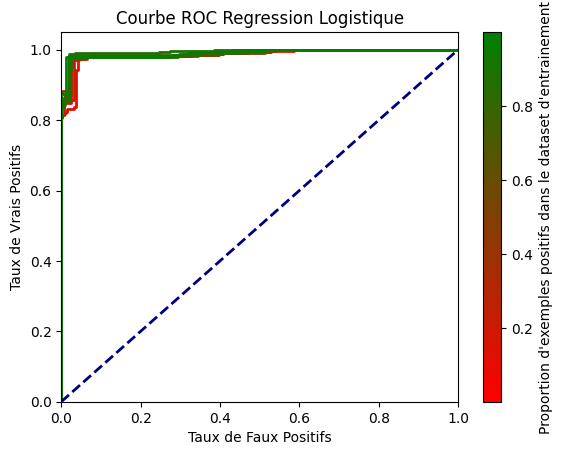

In [871]:
from sklearn.metrics import roc_curve, auc
from matplotlib.colors import LinearSegmentedColormap, Normalize

colors = ["red", "green"]
cmap = LinearSegmentedColormap.from_list("rg", colors, N=256)

values = np.linspace(0.001, 0.999, 10)

norm = Normalize(vmin=min(values), vmax=max(values))

fig, ax = plt.subplots()



for value in values:
    color = cmap(norm(value))
    df = dataset_divider(df_main, prop)
    X = df.drop('target', axis=1)
    y = df['target']
    X_train, X_test, y_train, y_test  = train_test_split(X, y, test_size= 0.2, stratify=y)
    model = LogisticRegression(max_iter=4000)
    model.fit(X_train, y= y_train)
    predictions = model.predict_proba(X_test)[:, 1]

    fpr, tpr, thresholds = roc_curve(y_test, predictions)
    roc_auc = auc(fpr, tpr)

    ax.plot(fpr, tpr, color=color, lw=2)

ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm)
cbar.set_label('Proportion d\'exemples positifs dans le dataset d\'entrainement')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taux de Faux Positifs')
plt.ylabel('Taux de Vrais Positifs')
plt.title('Courbe ROC Regression Logistique')
plt.savefig('roc_reg_log.png')
plt.show()

/var/folders/kn/pl0971pj1p358ll4phkv7xgw0000gn/T/ipykernel_27838/2379484962.py:34: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm)


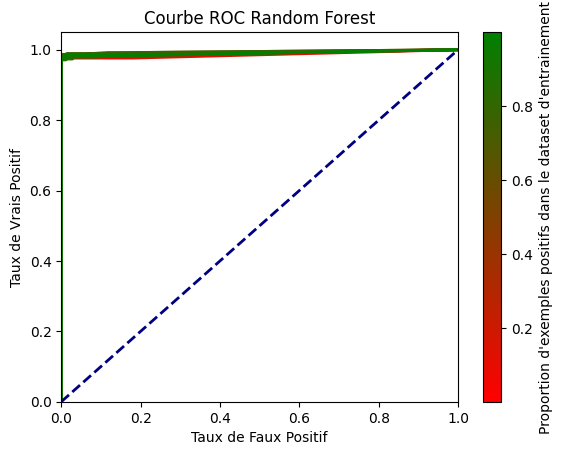

In [885]:
from sklearn.metrics import roc_curve, auc
from matplotlib.colors import LinearSegmentedColormap, Normalize

colors = ["red", "green"]
cmap = LinearSegmentedColormap.from_list("rg", colors, N=256)

values = np.linspace(0.001, 0.999, 10)

norm = Normalize(vmin=min(values), vmax=max(values))

fig, ax = plt.subplots()



for value in values:
    color = cmap(norm(value))
    df = dataset_divider(df_main, prop)
    X = df.drop('target', axis=1)
    y = df['target']
    X_train, X_test, y_train, y_test  = train_test_split(X, y, test_size= 0.2, stratify=y)
    model = RandomForestClassifier()
    model.fit(X_train, y= y_train)
    predictions = model.predict_proba(X_test)[:, 1]

    fpr, tpr, thresholds = roc_curve(y_test, predictions)
    roc_auc = auc(fpr, tpr)

    ax.plot(fpr, tpr, color=color, lw=2)

ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm)
cbar.set_label('Proportion d\'exemples positifs dans le dataset d\'entrainement')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taux de Faux Positif')
plt.ylabel('Taux de Vrais Positif')
plt.title('Courbe ROC Random Forest')
plt.savefig('roc_r_f.png')
plt.show()

 ### **Graphique comparant l'accuracy et le recall en fonction du pourcentage de 1 dans l'échantillon original**

In [904]:
from tqdm import tqdm

x_axis = np.linspace(1, 99, 99)

y_acc_l_r = []
y_rec_l_r = []
l_conf_inter_acc = []
l_conf_inter_rec = []
for thresh in tqdm(x_axis, total=len(x_axis), desc='Progression', ncols=100):
    acc_reg_log, conf_inter_acc = cross_val(df_main, class_1_percent = thresh/100, model_name = 'log_reg', n_cross_val = 50, score_type = 'accuracy', in_percent = False)
    rec_reg_log, conf_inter_rec = cross_val(df_main, class_1_percent = thresh/100, model_name = 'log_reg', n_cross_val = 50, score_type = 'recall', in_percent = False)
    y_acc_l_r.append(acc_reg_log)
    y_rec_l_r.append(rec_reg_log)
    l_conf_inter_acc.append(conf_inter_acc)
    l_conf_inter_rec.append(conf_inter_rec)
print("Done!")


Progression: 100%|██████████████████████████████████████████████████| 99/99 [06:03<00:00,  3.67s/it]

Done!


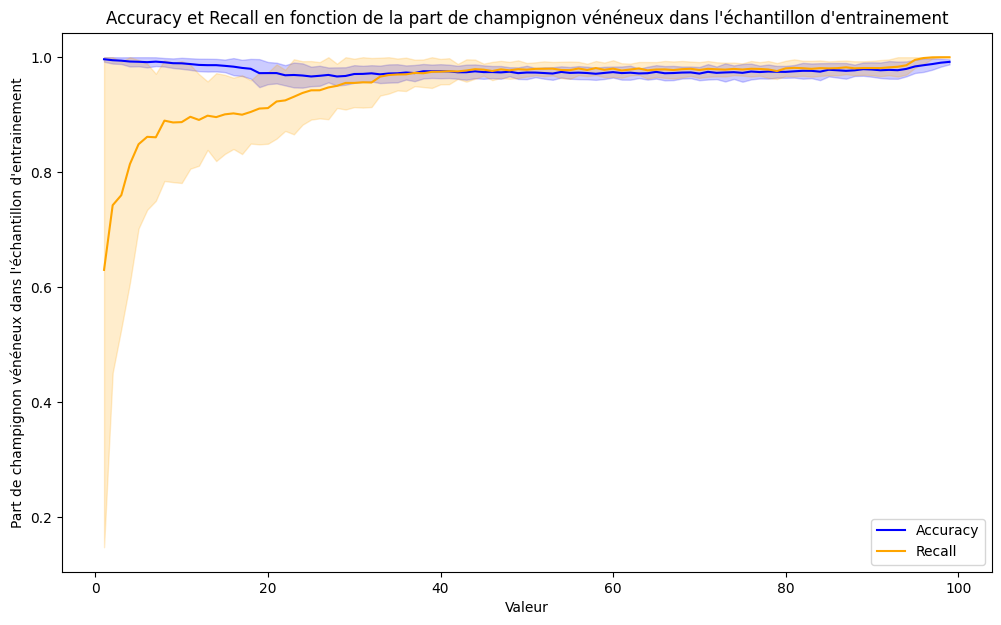

In [905]:
lows_acc_l_r, highs_acc_l_r = zip(*l_conf_inter_acc)
lows_rec_l_r, highs_rec_l_r = zip(*l_conf_inter_rec)

plt.figure(figsize=(12, 7))

plt.plot(x_axis, y_acc_l_r, label='Accuracy', color='blue')
plt.fill_between(x_axis, lows_acc_l_r, highs_acc_l_r, color='blue', alpha=0.2)

plt.plot(x_axis, y_rec_l_r, label='Recall', color='orange')
plt.fill_between(x_axis, lows_rec_l_r, highs_rec_l_r, color='orange', alpha=0.2)

plt.xlabel('Valeur')
plt.ylabel('Part de champignon vénéneux dans l\'échantillon d\'entrainement')
plt.title('Accuracy et Recall en fonction de la part de champignon vénéneux dans l\'échantillon d\'entrainement')
plt.legend(loc='lower right')
plt.savefig('Accuracy_Recall_log_reg.png')
plt.show()

Pour la régression logistique :

- **accuracy** : L'accuracy est meilleure lorsque la répartition des classes est plus biaisée. Cela s'explique par le fait qu'il s'agit du nombre de prédictions correctes sur les deux classes du modèle. Ainsi, si une classe contient un nombre disproportionnellement plus grand d'individus qu'une autre, il suffit que le modèle classe tous les individus dans cette classe dominante pour que l'accuracy soit tout de même proche de 1.

- **recall** : Le recall est influencé par le pourcentage d'exemples positifs dans l'échantillon d'entraînement et tend à se rapprocher de 1 lorsque la classe positive est plus présente dans le dataset. Plus le nombre d'individus de la classe positive est petit comparativement au nombre d'individus de la classe nulle, plus le modèle sera entraîné à classer la plupart des individus dans la classe nulle. En effet, avec très peu d'exemples d'individus appartenant à la classe positive présents dans le dataset, le modèle aura tendance à générer des faux négatifs. En conséquence, le recall va baisser.




In [906]:
x_axis = np.linspace(1, 99, 99)

y_acc_r_f = []
y_rec_r_f = []
l_conf_inter_acc_r_f = []
l_conf_inter_rec_r_f = []
for thresh in tqdm(x_axis, total=len(x_axis), desc='Progression', ncols=100):
    acc_r_f, conf_inter_acc = cross_val(df_main, class_1_percent = thresh/100, model_name = 'random_forest', n_cross_val = 50, score_type = 'accuracy', in_percent = False)
    rec_r_f, conf_inter_rec = cross_val(df_main, class_1_percent = thresh/100, model_name = 'random_forest', n_cross_val = 50, score_type = 'recall', in_percent = False)
    l_conf_inter_acc_r_f.append(conf_inter_acc)
    l_conf_inter_rec_r_f.append(conf_inter_rec)
    y_acc_r_f.append(acc_r_f)
    y_rec_r_f.append(rec_r_f)

Progression: 100%|██████████████████████████████████████████████████| 99/99 [11:34<00:00,  7.01s/it]


In [803]:
rec_reg_log

0.9975

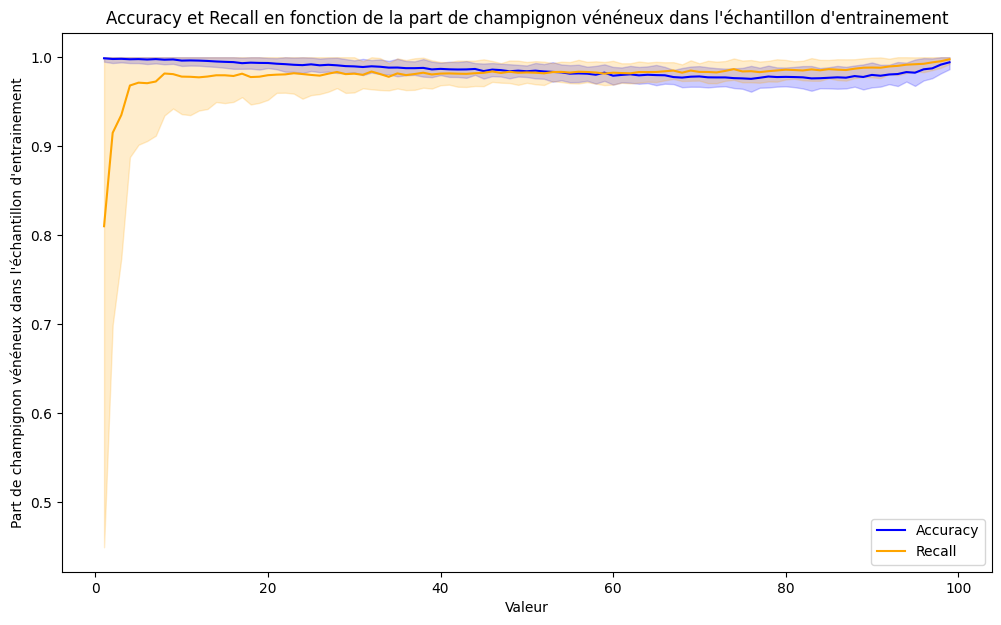

In [907]:
lows_acc, highs_acc = zip(*l_conf_inter_acc_r_f)
lows_rec, highs_rec = zip(*l_conf_inter_rec_r_f)

plt.figure(figsize=(12, 7))

plt.plot(x_axis, y_acc_r_f, label='Accuracy', color='blue')
plt.fill_between(x_axis, lows_acc, highs_acc, color='blue', alpha=0.2)

plt.plot(x_axis, y_rec_r_f, label='Recall', color='orange')
plt.fill_between(x_axis, lows_rec, highs_rec, color='orange', alpha=0.2)

plt.xlabel('Valeur')
plt.ylabel('Part de champignon vénéneux dans l\'échantillon d\'entrainement')
plt.title('Accuracy et Recall en fonction de la part de champignon vénéneux dans l\'échantillon d\'entrainement')
plt.legend(loc='lower right')
plt.savefig('Accuracy_Recall_r_f.png')
plt.show()

Pour le modèle **Random Forest** :

- **accuracy** : L'accuracy est au plus bas lorsque la part d'exemples positifs dans le dataset d'entraînement est proche de 80%. Cela peut suggérer que le modèle a des difficultés à bien classifier les exemples négatifs lorsque la majorité des données sont positives, entraînant une baisse globale de la précision.

- **recall** : Comme pour la régression logistique, le recall augmente beaucoup plus rapidement, atteignant 97% alors que la part d'exemples positifs n'est que d'environ 5%. Cela indique une forte capacité du modèle à identifier correctement les exemples positifs, même quand ils sont en minorité dans le dataset.


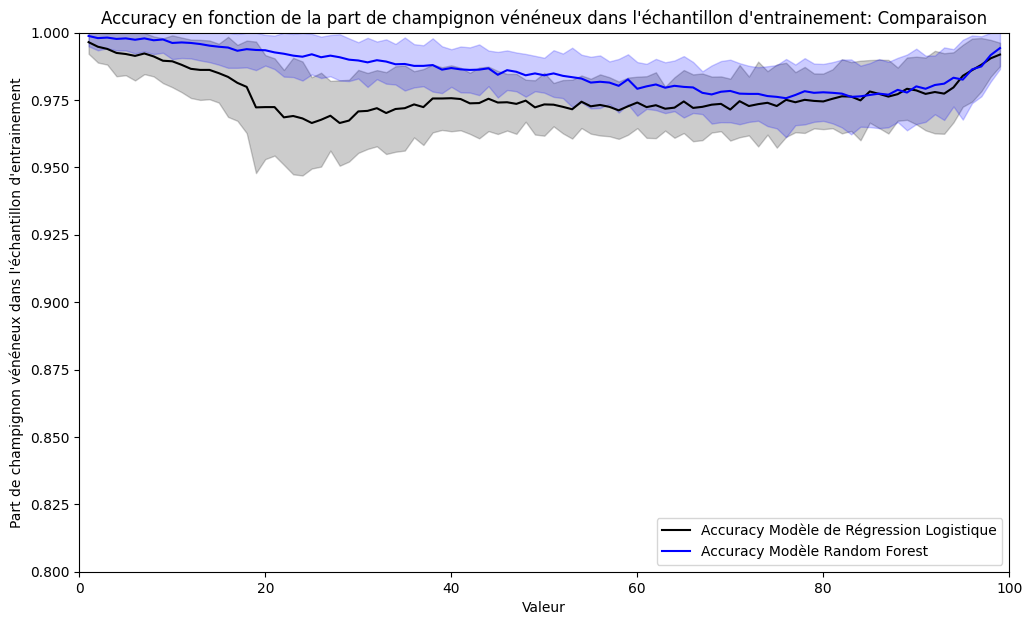

In [908]:
plt.figure(figsize=(12, 7))

plt.plot(x_axis, y_acc_l_r, label='Accuracy Modèle de Régression Logistique', color='black')
plt.fill_between(x_axis, lows_acc_l_r, highs_acc_l_r, color='black', alpha=0.2)

plt.plot(x_axis, y_acc_r_f, label= 'Accuracy Modèle Random Forest', color='blue')
plt.fill_between(x_axis, lows_acc, highs_acc, color='blue', alpha=0.2)

plt.xlim([0.0, 100.0])
plt.ylim([0.8, 1.0])
plt.xlabel('Valeur')
plt.ylabel('Part de champignon vénéneux dans l\'échantillon d\'entrainement')
plt.title('Accuracy en fonction de la part de champignon vénéneux dans l\'échantillon d\'entrainement: Comparaison')
plt.legend(loc='lower right')
plt.savefig('comp_acc.png')
plt.show()

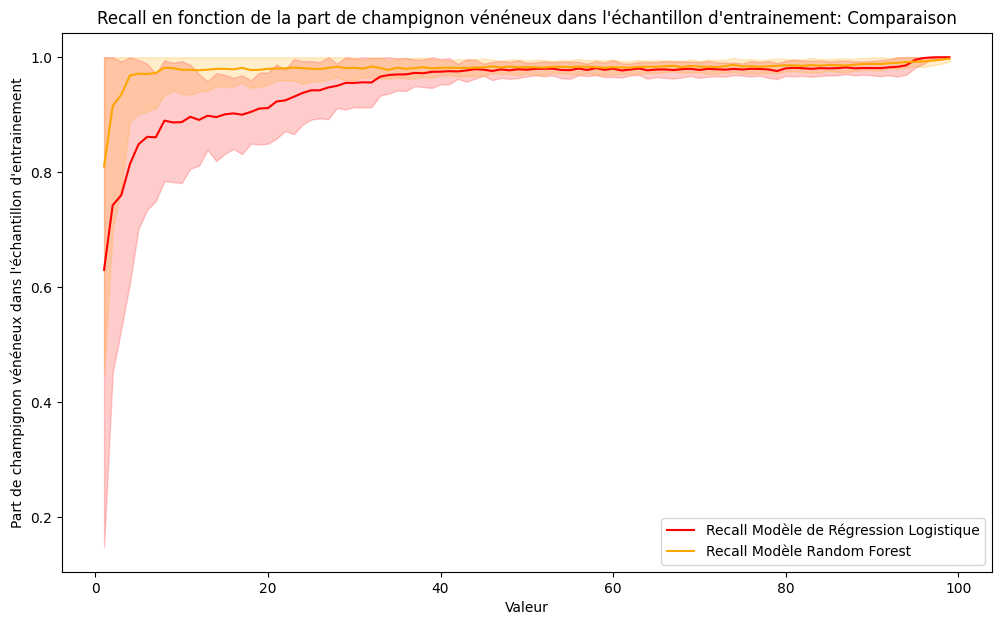

In [909]:
plt.figure(figsize=(12, 7))

plt.plot(x_axis, y_rec_l_r, label= 'Recall Modèle de Régression Logistique', color='red')
plt.fill_between(x_axis, lows_rec_l_r, highs_rec_l_r, color='red', alpha=0.2)

plt.plot(x_axis, y_rec_r_f, label= 'Recall Modèle Random Forest', color='orange')
plt.fill_between(x_axis, lows_rec, highs_rec, color='orange', alpha=0.2)

plt.xlabel('Valeur')
plt.ylabel('Part de champignon vénéneux dans l\'échantillon d\'entrainement')
plt.title('Recall en fonction de la part de champignon vénéneux dans l\'échantillon d\'entrainement: Comparaison')
plt.legend(loc='lower right')
plt.savefig('Recall_comp.png')
plt.show()